DSC680 Week 1-1 <BR>
Project 1 <BR>
Author Michael Paris <BR>
12/08/2022 <BR>

In [138]:
import pandas as pd
import numpy as np
import string

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.stem.porter import PorterStemmer

import regex as re

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.backend import eval
from tensorflow.keras.optimizers import Adam
from keras.layers import LSTM
from keras.layers.embeddings import Embedding

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

In [27]:
product_reviews_df = pd.read_csv('marketing_sample_for_walmart_com-walmart_product_reviews__20200401_20200630__30k_data.csv')

In [28]:
product_reviews_df.head()

,Uniq Id,Crawl Timestamp,Pageurl,Website,Title,Rating,Review,Reviewer Name,Review Upvotes,Review Downvotes,Verified Purchaser,Recommended Purchase,Review Date,Five Star,Four Star,Three Star,Two Star,One Star
0,1800878dcfa5255c691f2a87ce8b2869,2020-05-16 17:58:33 +0000,https://www.walmart.com/reviews/product/36907838,walmart.com,NaN,1.0,One star for looking nice. That’s it. After tr...,PJ10,0,0,No,No,7/28/2018,23.0,5.0,1.0,3.0,6.0
1,ac06ca1b77310d539c9a74eed7a8a8e2,2020-04-17 01:05:43 +0000,https://www.walmart.com/reviews/product/708236785,walmart.com,NaN,4.0,Love this phone so far have had it almost a mo...,KelJo,9,3,No,No,11/14/2017,91.0,23.0,13.0,9.0,31.0
2,9c4b10fff4e5e2cc7e2e1bbed76e2220,2020-06-08 10:35:05 +0000,https://www.walmart.com/reviews/product/831078728,walmart.com,NaN,4.0,This TV is absolutely fantastic. This is my th...,TheBigChalupa11,0,0,Yes,No,5/20/2020,32.0,8.0,1.0,0.0,0.0
3,b5a5dc8de9fc0468aab961f097b56091,2020-04-13 03:57:29 +0000,https://www.walmart.com/reviews/product/40712755,walmart.com,NaN,5.0,"Refurb, good shape, good price, does what I wa...",Micalic,0,0,No,No,7/9/2019,418.0,62.0,17.0,1.0,13.0
4,430433b52b882e540c16363d448e012b,2020-05-19 03:52:42 +0000,https://www.walmart.com/reviews/product/46597970,walmart.com,NaN,5.0,Very nice tablet! Looks brand new. Fired right...,jcan74,0,0,No,No,2/11/2020,213.0,57.0,25.0,24.0,87.0


In [44]:
#need to remove any nan from the reviews or ratings
print(product_reviews_df['Review'].count())
print(product_reviews_df['Review'].isnull().values.any())
print(product_reviews_df['Review'].isnull().sum())

print(product_reviews_df['Rating'].count())
print(product_reviews_df['Rating'].isnull().values.any())
print(product_reviews_df['Rating'].isnull().sum())

24617
True
5380
29997
False
0


In [30]:
#lets look at the datatypes that have been assigned to each column

product_reviews_df.dtypes

Uniq Id                  object
Crawl Timestamp          object
Pageurl                  object
Website                  object
Title                    object
Rating                  float64
Review                   object
Reviewer Name            object
Review Upvotes            int64
Review Downvotes          int64
Verified Purchaser       object
Recommended Purchase     object
Review Date              object
Five Star               float64
Four Star               float64
Three Star              float64
Two Star                float64
One Star                float64
dtype: object

In [46]:
#convert Rating from float to int (there are no reviews of 1.5, etc..)

product_reviews_df['Rating'] = product_reviews_df['Rating'].astype(int)

In [47]:
#convert the crawl timestamp to datetime
#convert verified purchaser to boolean

product_reviews_df['Crawl Timestamp'] = pd.to_datetime(product_reviews_df['Crawl Timestamp'])
#product_reviews_df['Verified Purchaser'] = product_reviews_df['Verified Purchaser'].astype('bool')

In [48]:
# remove the timestamp from the date
product_reviews_df['Crawl Timestamp'] = product_reviews_df['Crawl Timestamp'].dt.date


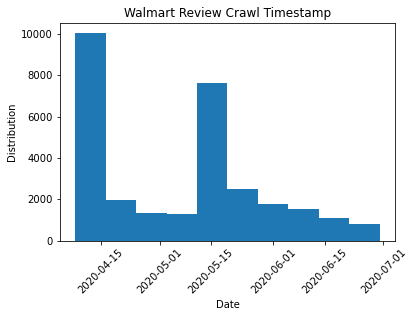

In [49]:
#lets look at the distribution for when the data was pulled.
# we want the data pulled within a reasonable timespan

plt.hist(product_reviews_df['Crawl Timestamp'])
plt.title('Walmart Review Crawl Timestamp')
plt.xlabel('Date')
plt.xticks(rotation = 45)
plt.ylabel('Distribution')
plt.show()

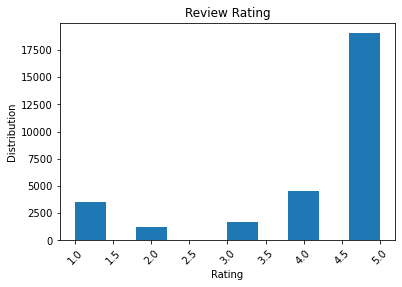

In [50]:
plt.hist(product_reviews_df['Rating'])
plt.title('Review Rating')
plt.xlabel('Rating')
plt.xticks(rotation = 45)
plt.ylabel('Distribution')
plt.show()

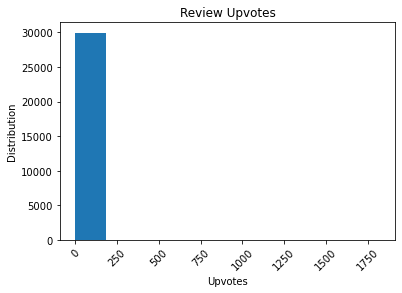

In [51]:
#should we compare the upvotes to downvotes or maybe look at the average?

plt.hist(product_reviews_df['Review Upvotes'])
plt.title('Review Upvotes')
plt.xlabel('Upvotes')
plt.xticks(rotation = 45)
plt.ylabel('Distribution')
plt.show()

<AxesSubplot:>

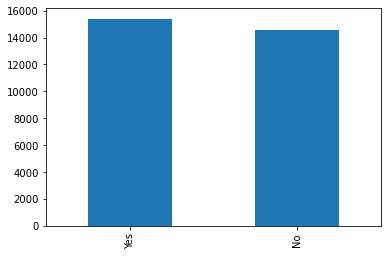

In [52]:
#should we compare the upvotes to downvotes or maybe look at the average?


product_reviews_df['Verified Purchaser'].value_counts().plot.bar()

#counts = table1.gt(0).astype(int).sum(axis=0).droplevel(0).reset_index(name='total')

#plt.figure(figsize=(9,10))
#product_reviews_df.plot(x=product_reviews_df['Verified Purchaser'].value_counts(), kind='bar')
#plt.title('Number of Hot Dogs Eaten by Contest Winner')
#plt.xlabel('Year')
#plt.ylabel('Dogs Eaten')
#plt.show()

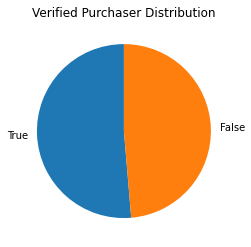

In [53]:
plt.pie(product_reviews_df['Verified Purchaser'].value_counts(), labels=['True', 'False'], startangle=90)
plt.title('Verified Purchaser Distribution')
plt.show()


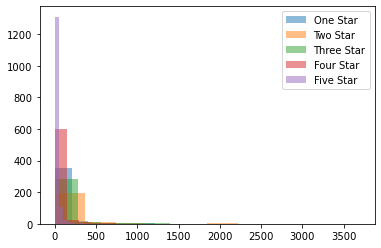

In [54]:
plt.hist(product_reviews_df['One Star'].value_counts(), alpha=0.5, label='One Star')
plt.hist(product_reviews_df['Two Star'].value_counts(), alpha=0.5, label='Two Star')
plt.hist(product_reviews_df['Three Star'].value_counts(), alpha=0.5, label='Three Star')
plt.hist(product_reviews_df['Four Star'].value_counts(), alpha=0.5, label='Four Star')
plt.hist(product_reviews_df['Five Star'].value_counts(), alpha=0.5, label='Five Star')
plt.legend()
plt.show()

In [55]:
product_reviews_df_clean=product_reviews_df.dropna(subset=['Review'])

In [56]:
product_reviews_df_clean.head()

,Uniq Id,Crawl Timestamp,Pageurl,Website,Title,Rating,Review,Reviewer Name,Review Upvotes,Review Downvotes,Verified Purchaser,Recommended Purchase,Review Date,Five Star,Four Star,Three Star,Two Star,One Star
0,1800878dcfa5255c691f2a87ce8b2869,2020-05-16,https://www.walmart.com/reviews/product/36907838,walmart.com,NaN,1,One star for looking nice. That’s it. After tr...,PJ10,0,0,No,No,7/28/2018,23.0,5.0,1.0,3.0,6.0
1,ac06ca1b77310d539c9a74eed7a8a8e2,2020-04-17,https://www.walmart.com/reviews/product/708236785,walmart.com,NaN,4,Love this phone so far have had it almost a mo...,KelJo,9,3,No,No,11/14/2017,91.0,23.0,13.0,9.0,31.0
2,9c4b10fff4e5e2cc7e2e1bbed76e2220,2020-06-08,https://www.walmart.com/reviews/product/831078728,walmart.com,NaN,4,This TV is absolutely fantastic. This is my th...,TheBigChalupa11,0,0,Yes,No,5/20/2020,32.0,8.0,1.0,0.0,0.0
3,b5a5dc8de9fc0468aab961f097b56091,2020-04-13,https://www.walmart.com/reviews/product/40712755,walmart.com,NaN,5,"Refurb, good shape, good price, does what I wa...",Micalic,0,0,No,No,7/9/2019,418.0,62.0,17.0,1.0,13.0
4,430433b52b882e540c16363d448e012b,2020-05-19,https://www.walmart.com/reviews/product/46597970,walmart.com,NaN,5,Very nice tablet! Looks brand new. Fired right...,jcan74,0,0,No,No,2/11/2020,213.0,57.0,25.0,24.0,87.0


In [57]:
product_reviews_df_final = product_reviews_df_clean[['Uniq Id','Pageurl','Rating', 'Review']]

In [58]:
product_reviews_df_final.head()

,Uniq Id,Pageurl,Rating,Review
0,1800878dcfa5255c691f2a87ce8b2869,https://www.walmart.com/reviews/product/36907838,1,One star for looking nice. That’s it. After tr...
1,ac06ca1b77310d539c9a74eed7a8a8e2,https://www.walmart.com/reviews/product/708236785,4,Love this phone so far have had it almost a mo...
2,9c4b10fff4e5e2cc7e2e1bbed76e2220,https://www.walmart.com/reviews/product/831078728,4,This TV is absolutely fantastic. This is my th...
3,b5a5dc8de9fc0468aab961f097b56091,https://www.walmart.com/reviews/product/40712755,5,"Refurb, good shape, good price, does what I wa..."
4,430433b52b882e540c16363d448e012b,https://www.walmart.com/reviews/product/46597970,5,Very nice tablet! Looks brand new. Fired right...


In [61]:
rating = product_reviews_df_final[(product_reviews_df_final['Rating'] == 1) | (product_reviews_df_final['Rating'] == 5)]
rating.shape

(18090, 4)

In [62]:
rating.head()

,Uniq Id,Pageurl,Rating,Review
0,1800878dcfa5255c691f2a87ce8b2869,https://www.walmart.com/reviews/product/36907838,1,One star for looking nice. That’s it. After tr...
3,b5a5dc8de9fc0468aab961f097b56091,https://www.walmart.com/reviews/product/40712755,5,"Refurb, good shape, good price, does what I wa..."
4,430433b52b882e540c16363d448e012b,https://www.walmart.com/reviews/product/46597970,5,Very nice tablet! Looks brand new. Fired right...
5,75359904b511a5766a76348a3de2203a,https://www.walmart.com/reviews/product/49987014,5,I purchased it a few months ago because my son...
6,f9b66f9350b442aa588357a909b0e2b1,https://www.walmart.com/reviews/product/837383635,5,great sound quality.... highly recommend!! Gre...


In [63]:
y = rating['Rating']
x = rating['Review'].reset_index()

In [67]:
X = x['Review']
print(X)

0        One star for looking nice. That’s it. After tr...
1        Refurb, good shape, good price, does what I wa...
2        Very nice tablet! Looks brand new. Fired right...
3        I purchased it a few months ago because my son...
4        great sound quality.... highly recommend!! Gre...
                               ...                        
18085    I'm pleased to say that the overall style fit ...
18086    My son got it for me for christmas i love it i...
18087    Ive had my t.v. since xmas. First thing that w...
18088    Good value, quality product, easy to setup, no...
18089    Movies long since forgottenabout my Roku about...
Name: Review, Length: 18090, dtype: object


In [65]:
#set up a function to remove punctuation and stop words from the text

def process_text(text):
    no_puncuation = [char for char in text if char not in string.punctuation]
    no_puncuation = ''.join(no_puncuation)
    
    return [word for word in no_puncuation.split() if word.lower() not in stopwords.words('english')]

In [68]:
transformer = CountVectorizer(analyzer=process_text).fit(X)

In [69]:
review = X[24]

In [72]:
transform = transformer.transform([review])
print(transform)

  (0, 296)	1
  (0, 7905)	1
  (0, 9147)	1
  (0, 11186)	1
  (0, 12144)	1
  (0, 12187)	1
  (0, 12628)	1
  (0, 13542)	1
  (0, 15573)	1
  (0, 16861)	1
  (0, 17859)	1
  (0, 22642)	1
  (0, 22656)	1
  (0, 22981)	1
  (0, 23011)	1


In [73]:
X = transformer.transform(X)

In [79]:
#split up the data into train and test sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [80]:
naive_bayes = MultinomialNB()
naive_bayes.fit(X_train, y_train)

MultinomialNB()

In [83]:
#make the predictions

nb_prediction = naive_bayes.predict(X_test)

In [85]:
#lets look at the confusion matrix

print(confusion_matrix(y_test, prediction))
print('\n')
print(classification_report(y_test, prediction))
naive_bayes.score(X_train, y_train)

[[ 653  247]
 [ 115 4412]]


              precision    recall  f1-score   support

           1       0.85      0.73      0.78       900
           5       0.95      0.97      0.96      4527

    accuracy                           0.93      5427
   macro avg       0.90      0.85      0.87      5427
weighted avg       0.93      0.93      0.93      5427



0.9621732606807234

In [87]:
#Support Vector Method

support_vector = SVC()
support_vector.fit(X_train, y_train) 


In [88]:
sv_prediction=support_vector.predict(X_test)

In [89]:
# Confusion Matrx - should put this in a function to not copy it multiple times.

print(confusion_matrix(y_test, sv_prediction))
print('\n')
print(classification_report(y_test, sv_prediction))
support_vector.score(X_train, y_train)

[[ 517  383]
 [  51 4476]]


              precision    recall  f1-score   support

           1       0.91      0.57      0.70       900
           5       0.92      0.99      0.95      4527

    accuracy                           0.92      5427
   macro avg       0.92      0.78      0.83      5427
weighted avg       0.92      0.92      0.91      5427



0.9764668719892601

In [91]:
#run k neighbor with 3 neighbors

K_Neighbor = KNeighborsClassifier(n_neighbors=3)
K_Neighbor.fit(X, y) 

KNeighborsClassifier(n_neighbors=3)

In [92]:
K_prediction = K_Neighbor.predict(X_test)

In [95]:
# confusion matrix

print(confusion_matrix(y_test, K_prediction))
print('\n')
print(classification_report(y_test, K_prediction))
K_Neighbor.score(X_train, y_train)

[[ 337  563]
 [  22 4505]]


              precision    recall  f1-score   support

           1       0.94      0.37      0.54       900
           5       0.89      1.00      0.94      4527

    accuracy                           0.89      5427
   macro avg       0.91      0.68      0.74      5427
weighted avg       0.90      0.89      0.87      5427



0.8953644476032536

In [103]:
#anything 3 or better will be considered positive(1), less than 3 is negative (0)

product_reviews_df_final['labeled_rating'] = ['1' if star >= 3 else '0' for star in product_reviews_df_final['Rating']]

C:\Users\mpari\AppData\Local\Temp\ipykernel_7608\3460133739.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  product_reviews_df_final['labeled_rating'] = ['1' if star >= 3 else '0' for star in product_reviews_df_final['Rating']]


In [104]:
product_reviews_df_final.head()

,Uniq Id,Pageurl,Rating,Review,tokenized_review,labeled_rating
0,1800878dcfa5255c691f2a87ce8b2869,https://www.walmart.com/reviews/product/36907838,1,One star for looking nice. That’s it. After tr...,"[one, star, look, nice, that, tri, tri, par, i...",0
1,ac06ca1b77310d539c9a74eed7a8a8e2,https://www.walmart.com/reviews/product/708236785,4,Love this phone so far have had it almost a mo...,"[love, phone, far, almost, month, bad, problem...",1
2,9c4b10fff4e5e2cc7e2e1bbed76e2220,https://www.walmart.com/reviews/product/831078728,4,This TV is absolutely fantastic. This is my th...,"[tv, absolut, fantast, third, 4k, tv, blow, aw...",1
3,b5a5dc8de9fc0468aab961f097b56091,https://www.walmart.com/reviews/product/40712755,5,"Refurb, good shape, good price, does what I wa...","[refurb, good, shape, good, price, want]",1
4,430433b52b882e540c16363d448e012b,https://www.walmart.com/reviews/product/46597970,5,Very nice tablet! Looks brand new. Fired right...,"[nice, tablet, look, brand, new, fire, right, ...",1


In [ ]:
stop_words = set(stopwords.words('english'))

In [100]:
#adding a new column to the dataframe to hold the cleaned and tokenized review
porter = PorterStemmer()

product_reviews_df_final['tokenized_review'] = ''
product_reviews_df_final['tokenized_review'] = product_reviews_df_final['Review'].str.lower()
product_reviews_df_final['tokenized_review'] = product_reviews_df_final['tokenized_review'].str.replace('[^\w\s]','')
product_reviews_df_final['tokenized_review'] = product_reviews_df_final['tokenized_review'].apply(word_tokenize)
product_reviews_df_final['tokenized_review'] = product_reviews_df_final['tokenized_review'].apply(lambda x: [word for word in x if word not in stop_words])
product_reviews_df_final['tokenized_review'] = product_reviews_df_final['tokenized_review'].apply(lambda x: [porter.stem(word) for word in x])


C:\Users\mpari\AppData\Local\Temp\ipykernel_7608\2410548894.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  product_reviews_df_final['tokenized_review'] = ''
C:\Users\mpari\AppData\Local\Temp\ipykernel_7608\2410548894.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  product_reviews_df_final['tokenized_review'] = product_reviews_df_final['Review'].str.lower()
C:\Users\mpari\AppData\Local\Temp\ipykernel_7608\2410548894.py:6: FutureWarning: The default value of regex will change from True to False in a 

In [101]:
product_reviews_df_final.head()

,Uniq Id,Pageurl,Rating,Review,tokenized_review
0,1800878dcfa5255c691f2a87ce8b2869,https://www.walmart.com/reviews/product/36907838,1,One star for looking nice. That’s it. After tr...,"[one, star, look, nice, that, tri, tri, par, i..."
1,ac06ca1b77310d539c9a74eed7a8a8e2,https://www.walmart.com/reviews/product/708236785,4,Love this phone so far have had it almost a mo...,"[love, phone, far, almost, month, bad, problem..."
2,9c4b10fff4e5e2cc7e2e1bbed76e2220,https://www.walmart.com/reviews/product/831078728,4,This TV is absolutely fantastic. This is my th...,"[tv, absolut, fantast, third, 4k, tv, blow, aw..."
3,b5a5dc8de9fc0468aab961f097b56091,https://www.walmart.com/reviews/product/40712755,5,"Refurb, good shape, good price, does what I wa...","[refurb, good, shape, good, price, want]"
4,430433b52b882e540c16363d448e012b,https://www.walmart.com/reviews/product/46597970,5,Very nice tablet! Looks brand new. Fired right...,"[nice, tablet, look, brand, new, fire, right, ..."


In [117]:
reviews = product_reviews_df_final['Review']
labels = product_reviews_df_final['labeled_rating']

In [120]:
def clean_document(doco):
    punctuation = string.punctuation
    punc_replace = ''.join([' ' for s in punctuation])
    doco_link_clean = re.sub(r'http\S+', '', doco)
    doco_clean_and = re.sub(r'&\S+', '', doco_link_clean)
    doco_clean_at = re.sub(r'@\S+', '', doco_clean_and)
    doco_clean = doco_clean_at.replace('-', ' ')
    doco_alphas = re.sub(r'\W +', ' ', doco_clean)
    trans_table = str.maketrans(punctuation, punc_replace)
    doco_clean = ' '.join([word.translate(trans_table) for word in doco_alphas.split(' ')])
    doco_clean = doco_clean.split(' ')
    p = re.compile(r'\s*\b(?=[a-z\d]*([a-z\d])\1{3}|\d+\b)[a-z\d]+', re.IGNORECASE)
    doco_clean = ([p.sub("", x).strip() for x in doco_clean])
    doco_clean = [word.lower() for word in doco_clean if len(word) > 2]
    doco_clean = ([i for i in doco_clean if i not in stop_words])
#     doco_clean = [spell(word) for word in doco_clean]
#     p = re.compile(r'\s*\b(?=[a-z\d]*([a-z\d])\1{3}|\d+\b)[a-z\d]+', re.IGNORECASE)
    doco_clean = ([p.sub("", x).strip() for x in doco_clean])
#     doco_clean = ([spell(k) for k in doco_clean])
    return doco_clean

In [121]:
review_cleans = [clean_document(doc) for doc in reviews];
sentences = [' '.join(r) for r in review_cleans ]

In [124]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)

In [125]:
text_sequences = np.array(tokenizer.texts_to_sequences(sentences))
sequence_dict = tokenizer.word_index
word_dict = dict((num, val) for (val, num) in sequence_dict.items())

C:\Users\mpari\AppData\Local\Temp\ipykernel_7608\2688887180.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  text_sequences = np.array(tokenizer.texts_to_sequences(sentences))


In [126]:
reviews_encoded = [];
for i,review in enumerate(review_cleans):
    reviews_encoded.append([sequence_dict[x] for x in review]);

(array([   6.,  231.,  428.,  576.,  916., 1154., 1397., 1401., 1308.,
        1109., 1003.,  941.,  916.,  820.,  727.,  611.,  648.,  586.,
         551.,  526.,  503.,  486.,  441.,  777.]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24]),
 <BarContainer object of 24 artists>)

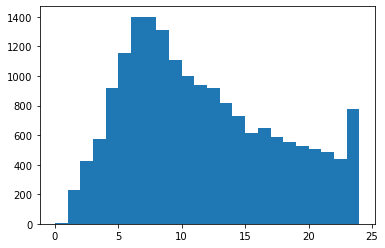

In [127]:
lengths = [len(x) for x in reviews_encoded]
plt.hist(lengths, bins=range(25))

In [129]:
max_cap =8;
X = pad_sequences(reviews_encoded, maxlen=max_cap, truncating='post')
Y = np.array([[0,1] if '0' in label else [1,0] for label in labels])

In [130]:
np.random.seed(1024);
random_posits = np.arange(len(X))
np.random.shuffle(random_posits);

In [131]:
X = X[random_posits];
Y = Y[random_posits];

In [133]:
train_cap = int(0.85 * len(X));
dev_cap = int(0.93 * len(X));

In [134]:
X_train, Y_train = X[:train_cap], Y[:train_cap]
X_dev, Y_dev = X[train_cap:dev_cap], Y[train_cap:dev_cap]
X_test1, Y_test1 = X[dev_cap:], Y[dev_cap:]

In [140]:
model1 = Sequential();
model1.add(Embedding(len(word_dict)+1, max_cap, input_length=max_cap));
#adding a LSTM layer of dim 1--
model1.add(LSTM(150, return_sequences=True));
model1.add(LSTM(150, return_sequences=False));
#adding a dense layer with activation function of relu
model1.add(Dense(100, activation='relu', kernel_initializer='uniform'));#best 50,relu
#adding the final output activation with activation function of softmax
model1.add(Dense(2, activation='sigmoid', kernel_initializer='uniform'));
print(model1.summary());
optimizer = Adam(lr=0.0001, decay=0.0001);

model1.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
# fit model and run it for 5 epochs
model1.fit(X_train, Y_train, batch_size=16, epochs=5, validation_data=(X_dev, Y_dev))

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 8, 8)              150960    
                                                                 
 lstm_2 (LSTM)               (None, 8, 150)            95400     
                                                                 
 lstm_3 (LSTM)               (None, 150)               180600    
                                                                 
 dense (Dense)               (None, 100)               15100     
                                                                 
 dense_1 (Dense)             (None, 2)                 202       
                                                                 
Total params: 442,262
Trainable params: 442,262
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/5


C:\Users\mpari\anaconda3\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


1308/1308 [==============================] - 19s 12ms/step - loss: 0.4253 - accuracy: 0.8345 - val_loss: 0.3598 - val_accuracy: 0.8456
Epoch 2/5
1308/1308 [==============================] - 16s 12ms/step - loss: 0.3235 - accuracy: 0.8655 - val_loss: 0.3321 - val_accuracy: 0.8624
Epoch 3/5
1308/1308 [==============================] - 18s 13ms/step - loss: 0.2879 - accuracy: 0.8796 - val_loss: 0.3189 - val_accuracy: 0.8695
Epoch 4/5
1308/1308 [==============================] - 17s 13ms/step - loss: 0.2615 - accuracy: 0.8911 - val_loss: 0.3105 - val_accuracy: 0.8705
Epoch 5/5
1308/1308 [==============================] - 17s 13ms/step - loss: 0.2399 - accuracy: 0.9015 - val_loss: 0.3090 - val_accuracy: 0.8730


In [141]:
score = model1.evaluate(X_test1, Y_test1)
print("Test accuracy: %0.4f%%" % (score[1]*100))

54/54 [==============================] - 0s 6ms/step - loss: 0.3121 - accuracy: 0.8718
Test accuracy: 87.1810%
